In [10]:
import os, sys, pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.preprocessing.image import ImageDataGenerator

sys.path.append('../src')
from model import build_model
import tensorflow as tf
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model

Cell 2 – Load All Labels & Split 80:20

In [4]:
df = pd.read_csv('../data/train.csv')
df['label'] = df['diagnosis'].apply(lambda x: 0 if x == 0 else 1)
df['image_path'] = df['id_code'].apply(lambda x: f"../data/train_images/{x}.png")

# Convert labels to string for Keras generator
df['label'] = df['label'].astype(str)

# First split into 80% train and 20% temp (val + test)
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

# Then split 20% temp into 10% val and 10% test
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['label'])
print(f"Train size: {len(train_df)}, Val size: {len(val_df)}, Test size: {len(test_df)}")


Train size: 2929, Val size: 366, Test size: 367


Cell 3 – Load Full Image Data (takes time)

In [5]:
train_aug = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2]
)

val_aug = ImageDataGenerator(rescale=1./255)
test_aug = ImageDataGenerator(rescale=1./255)

Cell 4 – Augment + Prepare Generators

In [7]:
train_gen = train_aug.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='label',
    target_size=(224, 224),
    batch_size=8,
    class_mode='binary'
)

val_gen = val_aug.flow_from_dataframe(
    dataframe=val_df,
    x_col='image_path',
    y_col='label',
    target_size=(224, 224),
    batch_size=8,
    class_mode='binary',
    shuffle=False
)

test_generator = test_aug.flow_from_dataframe(
    dataframe=test_df,
    x_col='image_path',
    y_col='label',
    target_size=(224, 224),
    batch_size=8,
    class_mode='binary',
    shuffle=False
)

Found 2929 validated image filenames belonging to 2 classes.
Found 366 validated image filenames belonging to 2 classes.
Found 367 validated image filenames belonging to 2 classes.


Cell 5 - Build Model (Freezing ResNet)

In [16]:
y_train_labels = train_df['label'].astype(int)
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_labels),
    y=y_train_labels
)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

Class Weights: {0: 1.014196675900277, 1: 0.9861952861952862}


In [ ]:
# model = build_model(input_shape=(224, 224, 3))

# history = model.fit(
#     train_gen,
#     steps_per_epoch=len(train_gen),
#     validation_data=val_gen,
#     validation_steps=len(val_gen),
#     class_weight=class_weights,
#     epochs=5
# )

Cell 6 - Compute Class Weights and Train

In [19]:
model = build_model(input_shape=(224, 224, 3))

history = model.fit(
    train_gen,
    steps_per_epoch=len(train_gen),
    validation_data=val_gen,
    validation_steps=len(val_gen),
    class_weight=class_weights,
    epochs=3
)

Epoch 1/3
367/367 [==============================] - 1737s 5s/step - loss: 0.5367 - accuracy: 0.7596 - val_loss: 0.7886 - val_accuracy: 0.4918
Epoch 2/3
367/367 [==============================] - 1155s 3s/step - loss: 0.4424 - accuracy: 0.8054 - val_loss: 0.6889 - val_accuracy: 0.5082
Epoch 3/3
367/367 [==============================] - 1154s 3s/step - loss: 0.3782 - accuracy: 0.8426 - val_loss: 0.4313 - val_accuracy: 0.8552


Cell 7 - save the model

In [20]:
model.save('../outputs/dr_model_epoch.keras')

Cell 8 - Evaluate Perfomance

In [21]:
y_probs = model.predict(val_gen, steps=len(val_gen), verbose=1)
y_pred = (y_probs > 0.5).astype(int)
y_true = val_gen.classes

print(confusion_matrix(y_true, y_pred))
print(classification_report(y_true, y_pred, zero_division=0))

46/46 [==============================] - 47s 978ms/step
[[173   7]
 [ 46 140]]
              precision    recall  f1-score   support

           0       0.79      0.96      0.87       180
           1       0.95      0.75      0.84       186

    accuracy                           0.86       366
   macro avg       0.87      0.86      0.85       366
weighted avg       0.87      0.86      0.85       366



Cell 9 - Plot accuracy and loss

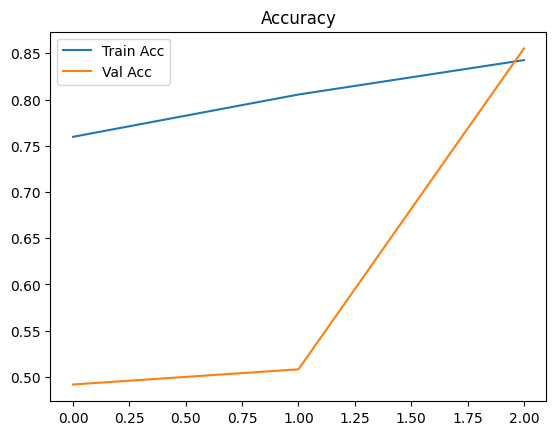

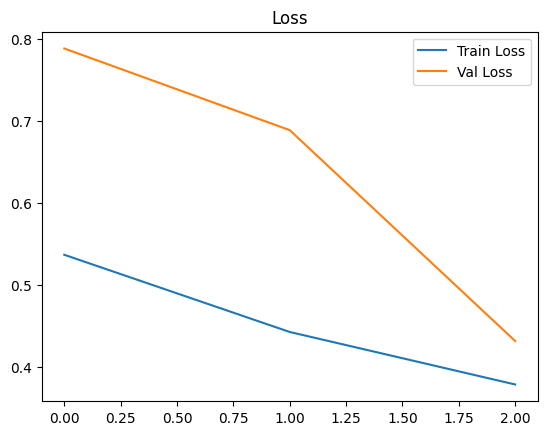

In [22]:
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy")
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss")
plt.legend()
plt.show()

In [23]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"\nTest Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

46/46 [==============================] - 61s 1s/step - loss: 0.4329 - accuracy: 0.8365

Test Accuracy: 0.8365
Test Loss: 0.4329


In [30]:
import numpy as np
import matplotlib.pyplot as plt

# STEP 1: Convert y_true to a NumPy array first
y_true = np.array(test_generator.classes).astype(np.float32)  

# STEP 2: Predict probabilities and flatten
y_probs = np.array(model.predict(test_generator, verbose=1)).flatten()

# STEP 3: Get predicted class (binary)
y_pred = (y_probs > 0.5).astype(np.int32)

# STEP 4: Per-image accuracy
per_image_accuracy = (y_pred == y_true).astype(np.int32)

# STEP 5: Binary cross-entropy loss per image
epsilon = 1e-7
per_image_loss = -(
    y_true * np.log(y_probs + epsilon) + (1 - y_true) * np.log(1 - y_probs + epsilon)
)


46/46 [==============================] - 45s 968ms/step


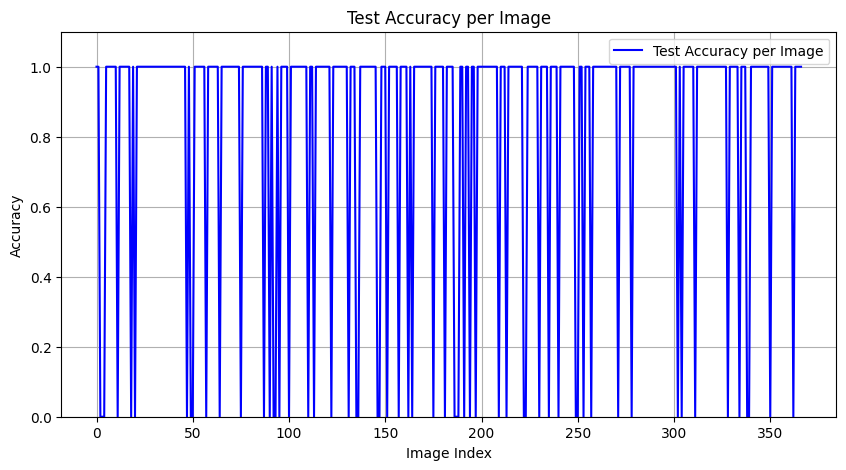

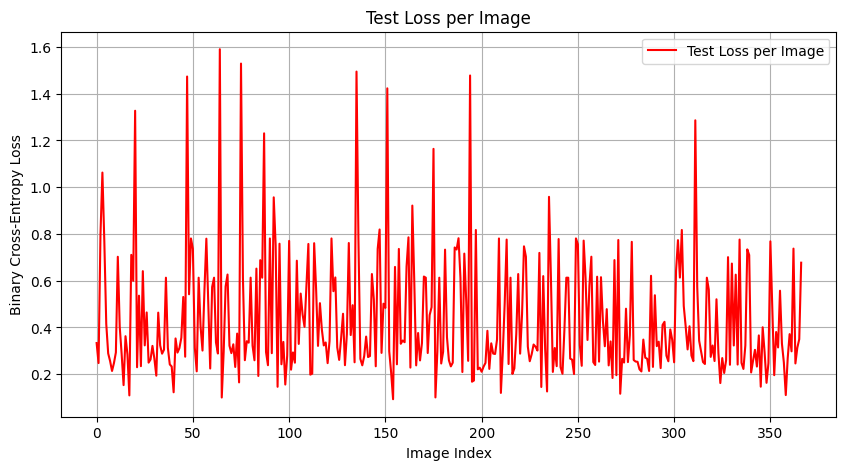

In [35]:
import numpy as np
import matplotlib.pyplot as plt

# Ensure y_true and y_probs are numpy arrays
y_true = np.array(y_true).astype(np.float32)
y_probs = np.array(y_probs).astype(np.float32)

# Predictions and per-image accuracy
y_preds = (y_probs > 0.5).astype(np.float32)
per_image_accuracy = (y_preds == y_true).astype(np.float32)

# Binary cross-entropy loss per image
epsilon = 1e-7
per_image_loss = -(
    y_true * np.log(y_probs + epsilon) + (1 - y_true) * np.log(1 - y_probs + epsilon)
)

image_indices = np.arange(len(y_true))

# === Plot 1: Per-image Accuracy ===
plt.figure(figsize=(10, 5))
plt.plot(image_indices, per_image_accuracy, color='blue', label='Test Accuracy per Image')
plt.title('Test Accuracy per Image')
plt.xlabel('Image Index')
plt.ylabel('Accuracy')
plt.ylim(0, 1.1)
plt.grid(True)
plt.legend()
plt.show()

# === Plot 2: Per-image Loss ===
plt.figure(figsize=(10, 5))
plt.plot(image_indices, per_image_loss, color='red', label='Test Loss per Image')
plt.title('Test Loss per Image')
plt.xlabel('Image Index')
plt.ylabel('Binary Cross-Entropy Loss')
plt.grid(True)
plt.legend()
plt.show()
